<a href="https://colab.research.google.com/github/omer358/ml-acamey/blob/master/potato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required libraries

In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

Conect the drive to load the dataset.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


unzip the dataset 

In [43]:
!unzip /content/drive/MyDrive/ml/Potato/PlantVillage.zip

Archive:  /content/drive/MyDrive/ml/Potato/PlantVillage.zip
replace PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [79]:
IMAGE_SIZE = 256
EPOCHS = 50
BATCH_SIZE = 32
CHANNELS = 3

Load the data using `tf.keras.preprocessing.image_dataset_from_directory`

In [46]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


The name of the classes of the potatos

In [67]:
class_names = dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [68]:
n_classes = len(class_names)

visualizing the dataset 

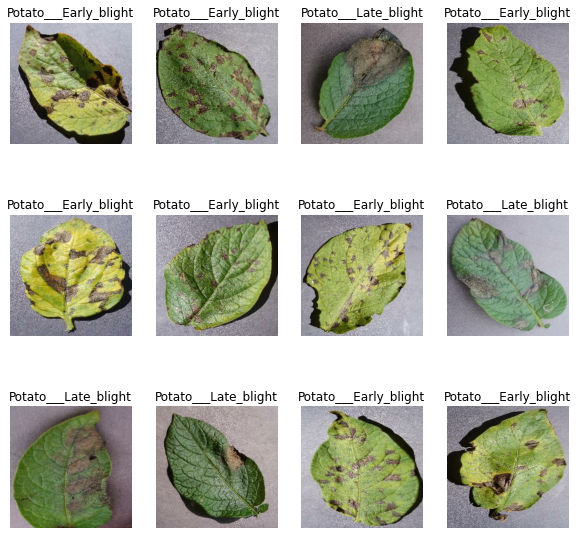

In [49]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [50]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [51]:
train_ds = dataset.take(54)
len(train_ds)

54

In [52]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [53]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [54]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [55]:
test_ds = test_ds.skip(6)
len(test_ds)

8

create a function to get the dataset from the disk and split it into `training`, `validation`, and `testing`.

In [56]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle : 
    ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [57]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [58]:
len(train_ds)

54

In [59]:
len(val_ds)

6

In [60]:
len(test_ds)

8

In [64]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

two layers will be added latter to the model, they are just a preprocessing step for resizeing the image to a united szie `256*256` pixels, the rescaling the image to `gray-scale` to reduce the computation power required by the model.

In [65]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

data augmentation is techniques used to increase the amount of data by adding slightly modified copies of already existing data.
Two layers has been added, the first layer `RandomFlip` to flip the sample horizontally and vertically, the second layer is to rotate the sample by 0.2

In [66]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Building the layer of the modelk, the first layers are just a punch of `Convoluational layers` to extract the features of the image,

In [74]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),
    activation='relu',
    input_shape=input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64,(3,3),
    activation='relu',
    input_shape=input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64,(3,3),
    activation='relu',
    input_shape=input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64,(3,3),
    activation='relu',
    input_shape=input_shape),
    layers.MaxPool2D(2,2),
    layers.Conv2D(64,(3,3),
    activation='relu',
    input_shape=input_shape),
    layers.MaxPool2D(2,2),
     layers.Conv2D(64,(3,3),
    activation='relu',
    input_shape=input_shape),
    layers.MaxPool2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [75]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   multiple                  0         
                                                                 
 sequential_7 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_13 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

In [77]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [81]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
)

Epoch 1/50


54/54 [==============================] - ETA: 0s - loss: 0.8914 - accuracy: 0.5185

54/54 [==============================] - 18s 133ms/step - loss: 0.8914 - accuracy: 0.5185 - val_loss: 0.8241 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 5s 93ms/step - loss: 0.7089 - accuracy: 0.6661 - val_loss: 0.6536 - val_accuracy: 0.7031
Epoch 3/50
54/54 [==============================] - 5s 90ms/step - loss: 0.4354 - accuracy: 0.8212 - val_loss: 0.2966 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 5s 93ms/step - loss: 0.2938 - accuracy: 0.8785 - val_loss: 0.2625 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 5s 90ms/step - loss: 0.2649 - accuracy: 0.9039 - val_loss: 0.2725 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 5s 89ms/step - loss: 0.2118 - accuracy: 0.9057 - val_loss: 0.1659 - val_accuracy: 0.9635
Epoch 7/50
54/54 [==============================] - 5s 90ms/step - loss: 0.2006 - accuracy: 0.9236 - val_loss: 0.1478 - val_accuracy: 0.9479
Epoch 8/50
54/54 [====

In [87]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 0s 32ms/step - loss: 0.0555 - accuracy: 0.9741


In [88]:
scores

[0.055495552718639374, 0.9741379022598267]

In [89]:
history

In [90]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'high right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


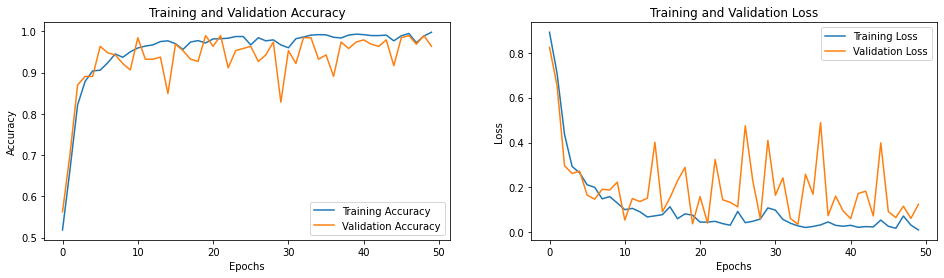

In [112]:
 plt.figure(figsize=(16,4))
 plt.subplot(1,2,1)
 plt.xlabel('Epochs')
 plt.ylabel("Accuracy")
 plt.plot(range(EPOCHS),acc,label='Training Accuracy')
 plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
 plt.legend(loc='lower right')
 plt.title("Training and Validation Accuracy")

 plt.subplot(1,2,2)
 plt.xlabel('Epochs')
 plt.ylabel("Loss")
 plt.plot(range(EPOCHS),loss,label='Training Loss')
 plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
 plt.legend(loc='high right')
 plt.title("Training and Validation Loss")
 plt.show()